In [1]:
%pip install xgboost
%pip install lightgbm


Note: you may need to restart the kernel to use updated packages.



In [2]:
"""
ADHD Prediction Dataset - Feature Engineering Module

This notebook performs feature engineering on the preprocessed ADHD dataset,
including correlation analysis, feature selection, and model comparison to
identify the optimal feature set and baseline model for ADHD prediction.

Author: [Your Name]
Date: [Date]
Project: ADHD Sex Prediction
Input: Preprocessed dataset from Data Preparation module
Output: Final engineered dataset and baseline model selection
"""

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb

# =============================================================================
# CONFIGURATION AND SETTINGS
# =============================================================================

# Set random seeds for reproducibility
RANDOM_SEEDS = [21, 42, 100, 123, 2025]
TEST_SIZE = 0.2
CORRELATION_THRESHOLD = 0.7





In [3]:
def load_and_inspect_data():
    # Load preprocessed data
    data_path = r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\notebooks\Data Preparation\balanced_adhd_dataset.csv"
    
    try:
        df = pd.read_csv(data_path)
        
        print(f" Samples: {df.shape[0]:,}")
        print(f" Features: {df.shape[1]:,}")
        
        return df 
        
    except FileNotFoundError:
        print(f"   ❌ Error: Dataset not found at {data_path}")
        raise
    except Exception as e:
        print(f"   ❌ Error loading dataset: {str(e)}")
        raise

# Load the dataset
df = load_and_inspect_data()  # This returns None!

 Samples: 1,341
 Features: 1,160


Analyzing correlations among 17 quantitative features...

 Correlation Analysis Results:
 Features analyzed: 17
 Correlation threshold: 0.7
 Highly correlated pairs found: 18

 Highly Correlated Feature Pairs:
 SDQ_SDQ_Conduct_Problems -> SDQ_SDQ_Difficulties_Total: 0.729
 SDQ_SDQ_Conduct_Problems -> SDQ_SDQ_Externalizing: 0.787
 SDQ_SDQ_Difficulties_Total -> SDQ_SDQ_Conduct_Problems: 0.729
 SDQ_SDQ_Difficulties_Total -> SDQ_SDQ_Externalizing: 0.886
 SDQ_SDQ_Difficulties_Total -> SDQ_SDQ_Generating_Impact: 0.734
 SDQ_SDQ_Difficulties_Total -> SDQ_SDQ_Hyperactivity: 0.789
 SDQ_SDQ_Difficulties_Total -> SDQ_SDQ_Internalizing: 0.831
 SDQ_SDQ_Emotional_Problems -> SDQ_SDQ_Internalizing: 0.835
 SDQ_SDQ_Externalizing -> SDQ_SDQ_Conduct_Problems: 0.787
 SDQ_SDQ_Externalizing -> SDQ_SDQ_Difficulties_Total: 0.886


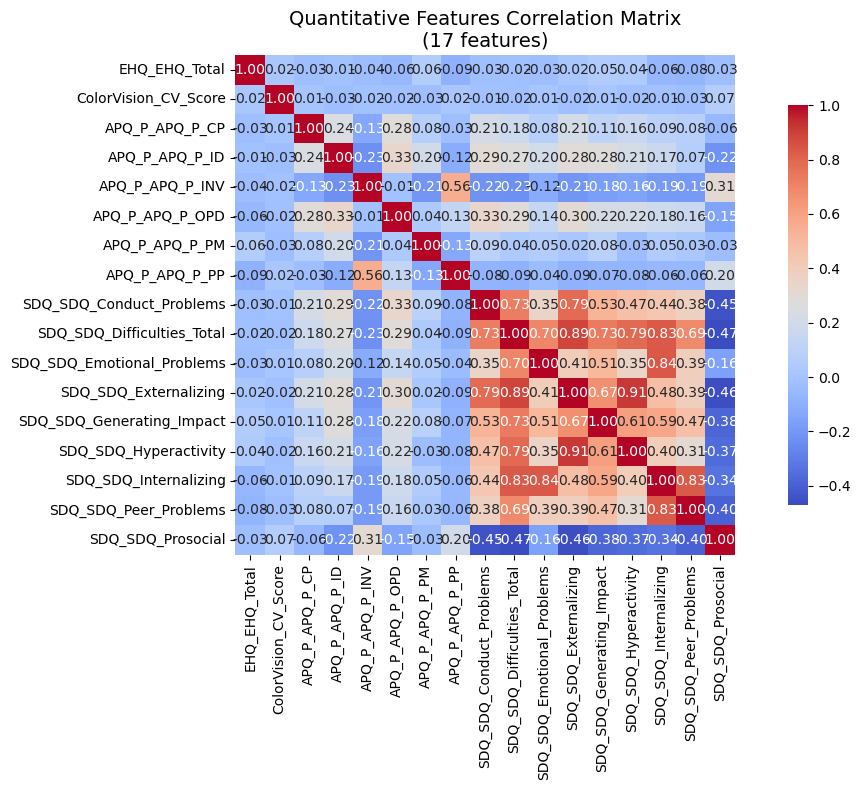

In [5]:
# =============================================================================
# FEATURE CORRELATION ANALYSIS
# =============================================================================

def analyze_feature_correlations(df, threshold=CORRELATION_THRESHOLD):
    """
    Analyze correlations among quantitative features and visualize results.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with features to analyze
    threshold : float
        Correlation threshold for identifying highly correlated features
    
    Returns:
    --------
    tuple
        (correlation_matrix, highly_correlated_pairs)
    """

    
    # Identify quantitative columns for correlation analysis
    quant_cols = [col for col in df.columns if 
                 (col.startswith('APQ_') or col.startswith('SDQ_') or 
                  col.startswith('EHQ_') or col.startswith('ColorVision')) 
                 and col in df.columns]
    
    print(f"Analyzing correlations among {len(quant_cols)} quantitative features...")
    
    if not quant_cols:
        print(f" No quantitative features found for correlation analysis")
        return None, []
    
    # Calculate correlation matrix
    corr = df[quant_cols].corr()
    
    # Find highly correlated pairs
    corr_pairs = corr.unstack()
    high_corr = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1.0)]
    
    print(f"\n Correlation Analysis Results:")
    print(f" Features analyzed: {len(quant_cols)}")
    print(f" Correlation threshold: {threshold}")
    print(f" Highly correlated pairs found: {len(high_corr)}")
    
    if len(high_corr) > 0:
        print(f"\n Highly Correlated Feature Pairs:")
        for (feat1, feat2), corr_val in high_corr.head(10).items():
            print(f" {feat1} -> {feat2}: {corr_val:.3f}")
    else:
        print(f"No highly correlated features above threshold")
    
    # Create correlation heatmap
   
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True,
               cbar_kws={"shrink": .8})
    plt.title(f'Quantitative Features Correlation Matrix\n({len(quant_cols)} features)', 
              fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return corr, high_corr

# Analyze correlations
corr_matrix, high_corr_pairs = analyze_feature_correlations(df)


In [6]:
# =============================================================================
# REDUNDANT FEATURE REMOVAL
# =============================================================================

def remove_highly_correlated_features(df, corr_matrix, threshold=CORRELATION_THRESHOLD):
    """
    Remove highly correlated features to reduce multicollinearity.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with features
    corr_matrix : pd.DataFrame
        Correlation matrix of features
    threshold : float
        Correlation threshold for feature removal
    
    Returns:
    --------
    tuple
        (df_filtered, dropped_features) - Dataset after removal and list of dropped features
    """
   
    
    
    # Find highly correlated pairs
    corr_pairs = corr_matrix.unstack()
    high_corr = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1.0)]
    
    # Determine which features to drop
    to_drop = set()
    feature_pairs = []
    
    for (col1, col2), corr_val in high_corr.items():
        if col1 not in to_drop and col2 not in to_drop:
            feature_pairs.append((col1, col2, corr_val))
            
            # Drop feature with more missing values (or first one if equal)
            missing_col1 = df[col1].isnull().sum()
            missing_col2 = df[col2].isnull().sum()
            
            if missing_col1 > missing_col2:
                to_drop.add(col1)
                dropped_feature = col1
                kept_feature = col2
            elif missing_col2 > missing_col1:
                to_drop.add(col2)
                dropped_feature = col2
                kept_feature = col1
            else:
                # If equal missing values, drop the first one alphabetically
                if col1 < col2:
                    to_drop.add(col2)
                    dropped_feature = col2
                    kept_feature = col1
                else:
                    to_drop.add(col1)
                    dropped_feature = col1
                    kept_feature = col2
            
            print(f" Dropping {dropped_feature} (corr with {kept_feature}: {corr_val:.3f})")
    
    # Remove highly correlated features
    original_shape = df.shape
    
    if to_drop:
        print(f"\n Feature Removal Summary:")
        print(f"  Features to drop: {len(to_drop)}")
        print(f"  Dropped features: {sorted(list(to_drop))}")
        
        df = df.drop(columns=list(to_drop))
        
        print(f"\n   📈 Dataset Shape Changes:")
        print(f"      • Before: {original_shape[0]:,} rows × {original_shape[1]:,} columns")
        print(f"      • After: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
        print(f"      • Features removed: {len(to_drop)}")
        print(f"      • Features retained: {df.shape[1] - original_shape[1] + len(to_drop)}")
        
    else:
        print(f"  No highly correlated features found to drop")
        df = df.copy()
    
    return df, list(to_drop)

# Remove highly correlated features
df, dropped_features = remove_highly_correlated_features(df, corr_matrix)

 Dropping SDQ_SDQ_Difficulties_Total (corr with SDQ_SDQ_Conduct_Problems: 0.729)
 Dropping SDQ_SDQ_Externalizing (corr with SDQ_SDQ_Conduct_Problems: 0.787)
 Dropping SDQ_SDQ_Internalizing (corr with SDQ_SDQ_Emotional_Problems: 0.835)

 Feature Removal Summary:
  Features to drop: 3
  Dropped features: ['SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing']

   📈 Dataset Shape Changes:
      • Before: 1,341 rows × 1,160 columns
      • After: 1,341 rows × 1,157 columns
      • Features removed: 3
      • Features retained: 0



 Target Variable Summary:

 Evaluating Logistic Regression:
 Seed   21 (Run 1): F1 = 0.8400
 Seed   42 (Run 2): F1 = 0.8364
 Seed  100 (Run 3): F1 = 0.8470
 Seed  123 (Run 4): F1 = 0.8066
 Seed 2025 (Run 5): F1 = 0.8327
  Summary: Mean = 0.8325 ± 0.0138
Range = [0.8066, 0.8470]

 Evaluating Random Forest:
 Seed   21 (Run 1): F1 = 0.8549
 Seed   42 (Run 2): F1 = 0.8765
 Seed  100 (Run 3): F1 = 0.8389
 Seed  123 (Run 4): F1 = 0.8810
 Seed 2025 (Run 5): F1 = 0.8466
  Summary: Mean = 0.8596 ± 0.0165
Range = [0.8389, 0.8810]

 Evaluating SVM:
 Seed   21 (Run 1): F1 = 0.7730
 Seed   42 (Run 2): F1 = 0.7508
 Seed  100 (Run 3): F1 = 0.7955
 Seed  123 (Run 4): F1 = 0.7955
 Seed 2025 (Run 5): F1 = 0.7986
  Summary: Mean = 0.7827 ± 0.0184
Range = [0.7508, 0.7986]

 Evaluating XGBoost:
 Seed   21 (Run 1): F1 = 0.8327
 Seed   42 (Run 2): F1 = 0.8624
 Seed  100 (Run 3): F1 = 0.8807
 Seed  123 (Run 4): F1 = 0.8586
 Seed 2025 (Run 5): F1 = 0.8587
  Summary: Mean = 0.8586 ± 0.0153
Range = [0.8327, 0.8

C:\Users\04ama\AppData\Local\Temp\ipykernel_38316\3321531800.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(score_data, labels=model_names, patch_artist=True)


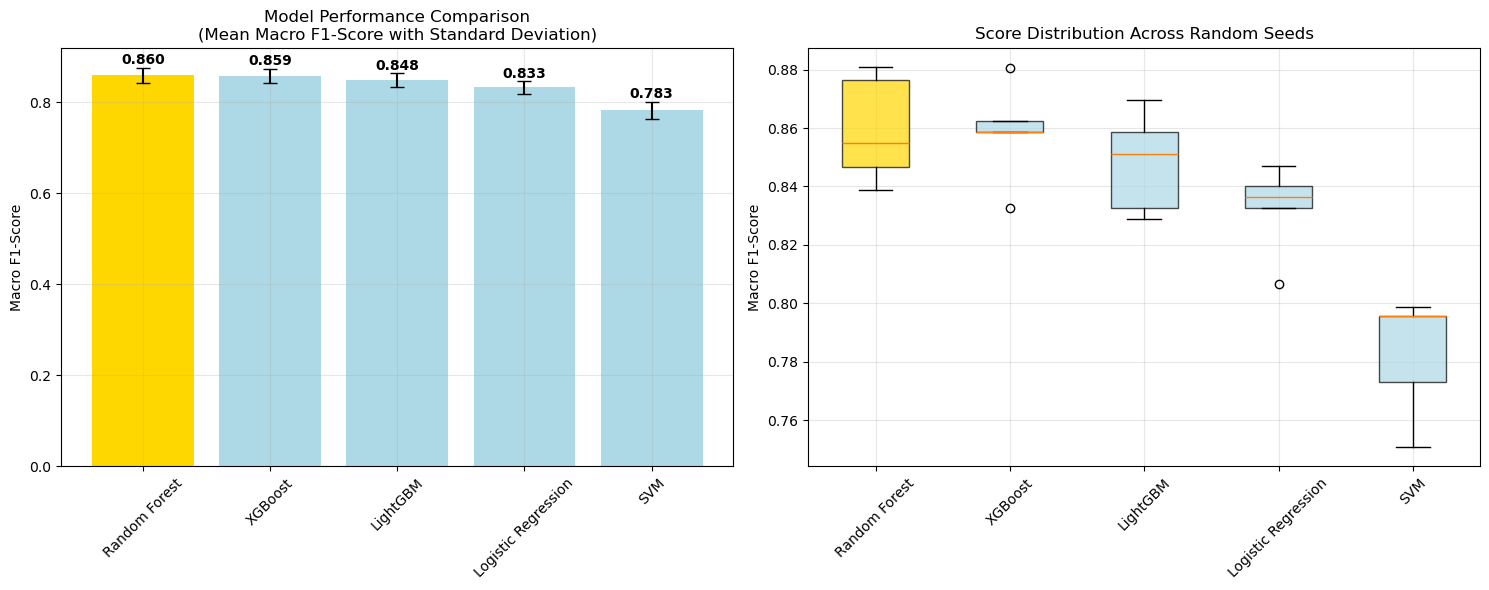

In [7]:
# =============================================================================
# MODEL COMPARISON AND EVALUATION
# =============================================================================

def prepare_features_target(df, target_col='ADHD_Outcome'):
    """
    Prepare feature matrix and target vector for model training.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with features and target
    target_col : str
        Name of target column
    
    Returns:
    --------
    tuple
        (X, y) - Feature matrix and target vector
    """
  
  
    
    # Prepare features (exclude target and identifier columns)
    exclude_cols = [target_col, 'participant_id']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols]
    y = df[target_col]
    
    

    
    print(f"\n Target Variable Summary:")
    target_counts = y.value_counts().sort_index()
    target_props = y.value_counts(normalize=True).sort_index()
    
    return X, y

def evaluate_models_with_multiple_seeds(X, y, seeds=RANDOM_SEEDS, test_size=TEST_SIZE):
    """
    Evaluate multiple models across different random seeds for stability assessment.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target vector
    seeds : list
        List of random seeds for evaluation
    test_size : float
        Test set proportion
    
    Returns:
    --------
    dict
        Model evaluation results
    """

    
    # Define models to evaluate
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(),
        "XGBoost": xgb.XGBClassifier(random_state=42, enable_categorical=True),
        "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1)
    }
    

    

    
    results = {}
    
    for name, model in models.items():
        print(f"\n Evaluating {name}:")
        macro_f1_scores = []
        
        for i, seed in enumerate(seeds, 1):
            # Split data with current seed
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=seed, stratify=y
            )
            
            # Train and evaluate model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Calculate macro F1-score
            report = classification_report(y_test, y_pred, output_dict=True)
            macro_f1 = report['macro avg']['f1-score']
            macro_f1_scores.append(macro_f1)
            
            print(f" Seed {seed:4d} (Run {i}): F1 = {macro_f1:.4f}")
        
        # Calculate statistics across seeds
        mean_f1 = np.mean(macro_f1_scores)
        std_f1 = np.std(macro_f1_scores)
        min_f1 = np.min(macro_f1_scores)
        max_f1 = np.max(macro_f1_scores)
        
        results[name] = {
            'scores': macro_f1_scores,
            'mean': mean_f1,
            'std': std_f1,
            'min': min_f1,
            'max': max_f1
        }
        
        print(f"  Summary: Mean = {mean_f1:.4f} ± {std_f1:.4f}")
        print(f"Range = [{min_f1:.4f}, {max_f1:.4f}]")
    
    return results

def analyze_model_results(results):
    """
    Analyze and visualize model evaluation results.
    
    Parameters:
    -----------
    results : dict
        Model evaluation results from evaluate_models_with_multiple_seeds
    """

    print(f" Model Performance")
    
    # Sort models by mean performance
    sorted_results = sorted(results.items(), key=lambda x: x[1]['mean'], reverse=True)
    
    for rank, (name, stats) in enumerate(sorted_results, 1):
        print(f"      {rank}. {name}:")
        print(f"    Mean Macro F1: {stats['mean']:.4f}")
        print(f"     Std Deviation: {stats['std']:.4f}")
        print(f"   Stability: {'High' if stats['std'] < 0.01 else 'Medium' if stats['std'] < 0.02 else 'Low'}")
    
    # Identify best model
    best_model = sorted_results[0][0]
    best_stats = sorted_results[0][1]
    
    print(f" Best Model Selection:")
    print(f"{best_model}")
    print(f"      Mean Performance: {best_stats['mean']:.4f}")
    print(f"      Stability (Std): {best_stats['std']:.4f}")
    
    # Create visualization
 
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot of mean scores with error bars
    model_names = [name for name, _ in sorted_results]
    mean_scores = [stats['mean'] for _, stats in sorted_results]
    std_scores = [stats['std'] for _, stats in sorted_results]
    
    bars = ax1.bar(model_names, mean_scores, yerr=std_scores, capsize=5, 
                   color=['gold' if i == 0 else 'lightblue' for i in range(len(model_names))])
    ax1.set_title('Model Performance Comparison\n(Mean Macro F1-Score with Standard Deviation)')
    ax1.set_ylabel('Macro F1-Score')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean_val, std_val in zip(bars, mean_scores, std_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std_val + 0.001,
                f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Box plot for score distributions
    score_data = [stats['scores'] for _, stats in sorted_results]
    box_plot = ax2.boxplot(score_data, labels=model_names, patch_artist=True)
    
    # Color the best model's box differently
    for i, patch in enumerate(box_plot['boxes']):
        if i == 0:  # Best model
            patch.set_facecolor('gold')
            patch.set_alpha(0.7)
        else:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
    
    ax2.set_title('Score Distribution Across Random Seeds')
    ax2.set_ylabel('Macro F1-Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return best_model, best_stats

# Prepare features and target
X, y = prepare_features_target(df)

# Evaluate models
evaluation_results = evaluate_models_with_multiple_seeds(X, y)

# Analyze results
best_model_name, best_model_stats = analyze_model_results(evaluation_results)

# testing models after feature selection 

In [8]:
# =============================================================================
# FINAL DATASET EXPORT
# =============================================================================

def export_final_dataset(df, filename='final_dataset.csv'):
    """
    Export the final engineered dataset for model training.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Final processed dataset
    filename : str
        Output filename
    """
    
    try:
        # Save final dataset
        df.to_csv(filename, index=False)
        
    except Exception as e:
        print(f"  Error exporting dataset: {str(e)}")
        raise

# Export final dataset
export_final_dataset(df, 'final_dataset.csv')



## Model Stability and Selection Conclusion

Based on repeated experiments with different random seeds, Logistic Regression achieved the highest mean macro F1-score and demonstrated good stability compared to other models. This indicates that Logistic Regression is the most effective and reliable baseline model for this dataset, outperforming more complex models such as Random Forest, SVM, XGBoost, and LightGBM. Therefore, Logistic Regression is recommended as the primary model for further analysis and optimization.